In [18]:
import sbibm
import sbi
from sbi.inference import SNPE
import corner
from sbi.neural_nets.net_builders import build_maf, build_nsf
from torch import ones, eye
from torch.optim import Adam, AdamW
import torch
import torch.nn as nn
from sbi.inference.posteriors import DirectPosterior
import matplotlib.pyplot as plt

In [12]:
task = sbibm.get_task("two_moons")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
prior_dist = task.get_prior_dist()
simulator = task.get_simulator()
observation = task.get_observation(num_observation=1)
reference_samples = task.get_reference_posterior_samples(num_observation=1)

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, in_features=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 2),
        )

    def forward(self, x):
        return self.net(x)

In [21]:
thetas = prior(num_samples=10_000)
xs = simulator(thetas)

test_thetas = prior(num_samples=1_000)
test_xs = simulator(test_thetas)

In [28]:
class NPEData(torch.utils.data.Dataset):

    def __init__(self,
                 num_samples: int,
                 prior: torch.distributions.Distribution,
                 simulator,
                 seed: int = 44):
        super().__init__()

        torch.random.manual_seed(seed) #will set the seed device wide
        self.prior = prior
        self.simulator = simulator

        self.theta = prior.sample((num_samples,))
        self.x = simulator(self.theta)

    def __len__(self):
        return self.theta.shape[0]

    def __getitem__(self, index:int):
        return self.theta[index,...], self.x[index,...]

In [29]:
train_data = NPEData(num_samples=10_000, prior=prior_dist, simulator=simulator)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128)
val_data = NPEData(num_samples=1_000, prior=prior_dist, simulator=simulator)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128)

In [24]:
density_estimator = build_nsf(thetas, xs, embedding_net=EmbeddingNet())
opt = AdamW(list(density_estimator.parameters()), lr=5e-4)

import tqdm
train_loss_arr = []
val_loss_arr = []
for _ in tqdm.tqdm(range(500)):
    density_estimator.train()
    opt.zero_grad()
    losses = density_estimator.loss(thetas, condition=xs)
    loss = torch.mean(losses)
    train_loss_arr.append(loss.item())
    loss.backward()
    opt.step()

    density_estimator.eval()
    with torch.no_grad():
        losses = density_estimator.loss(test_thetas, condition=test_xs)
        loss = torch.mean(losses)
        val_loss_arr.append(loss.item())

100%|██████████| 500/500 [01:13<00:00,  6.84it/s]


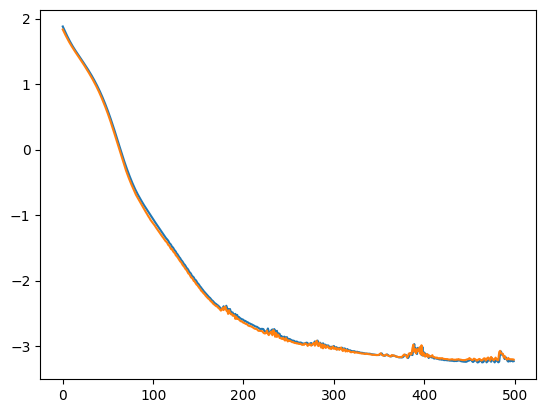

In [25]:
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)

In [26]:
posterior = DirectPosterior(density_estimator, prior_dist)
samples = posterior.sample((10_000,), x=observation).detach()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

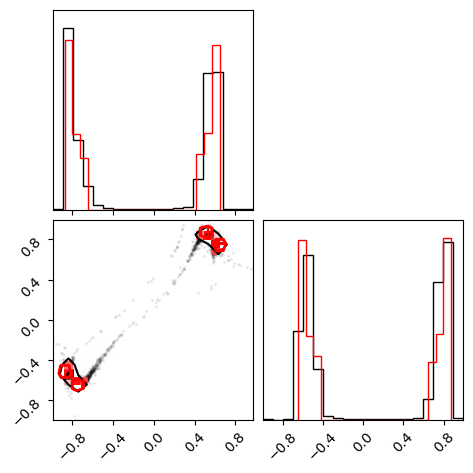

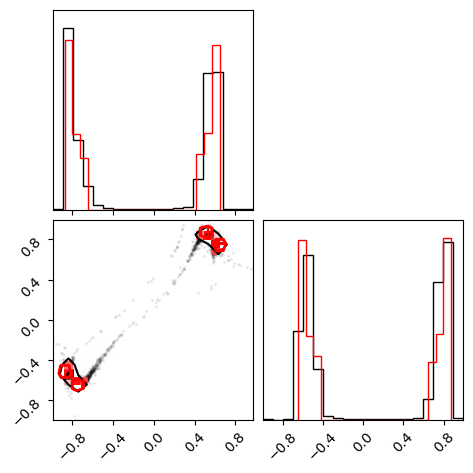

In [27]:
fig = corner.corner(samples.numpy())
corner.corner(reference_samples.numpy(), color="red", fig=fig)